In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as td
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(0)
data_path = 'content'
version = 2

In [116]:
df = pd.read_csv(f'{data_path}/data.csv')

In [117]:
target = 'Air Quality'
features = ['CO', 'NO2', 'Population_Density', 'Proximity_to_Industrial_Areas', 'Temperature']

dict = { key : value for value, key in enumerate(df['Air Quality'].value_counts().index)}
df[target] = df['Air Quality'].map(dict)
df = df[features + [target]]
df.head()

,CO,NO2,Population_Density,Proximity_to_Industrial_Areas,Temperature,Air Quality
0,1.72,18.9,319,6.3,29.8,1
1,1.64,30.8,611,6.0,28.3,1
2,1.63,24.4,619,5.2,23.1,1
3,1.15,13.5,551,11.1,27.1,0
4,1.01,21.9,303,12.7,26.5,0


In [118]:
max_values = df.drop(columns=[target]).max()  
df.iloc[:, :-1] = df.iloc[:, :-1] / max_values

/var/folders/10/vcvbnp396238kmcwww0pldcc0000gn/T/ipykernel_2050/2767821176.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.333333
1       0.638454
2       0.646813
3       0.575758
4       0.316614
          ...   
4995    0.799373
4996    0.740857
4997    0.396029
4998    0.251829
4999    0.481714
Name: Population_Density, Length: 5000, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, :-1] = df.iloc[:, :-1] / max_values


In [119]:
x_train, x_test, y_train, y_test = train_test_split(df[features].values,
                                                    df[target].values,
                                                    test_size=0.20,
                                                    random_state=0,
                                                    stratify=df[target])


In [137]:
class AirQualityNet(torch.nn.Module):
    def __init__(self):
        super(AirQualityNet, self).__init__()
        self.fc1 = torch.nn.Linear(5, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10, 10)
        self.fc4 = torch.nn.Linear(10, 4)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

In [138]:
def train(model, data_loader, optimizer, loss_criteria):
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, _target = tensor
        optimizer.zero_grad()
        
        out = model(data)
        loss = loss_criteria(out, _target)  # Ensure _target is integer labels
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = train_loss / (batch + 1)
    print(f'Training set: Average loss: {avg_loss:.6f}')
    return avg_loss

def test(model, data_loader, loss_criteria):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, _target = tensor
            
            out = model(data)
            test_loss += loss_criteria(out, _target).item()

            predicted = torch.argmax(out, dim=1)  # Multi-class prediction
            correct += (predicted == _target).sum().item()
            
    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / len(data_loader.dataset)
    
    print(f'Validation set: Average loss: {avg_loss:.6f}, Accuracy: {correct}/{len(data_loader.dataset)} ({accuracy:.2f}%)\n')
    return avg_loss

In [139]:
train_x = torch.tensor(x_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.int64)

# Create dataset and dataloader
train_ds = td.TensorDataset(train_x, train_y)
train_loader = td.DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=1)

# Convert x_test and y_test to tensors
test_x = torch.tensor(x_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.int64)

# Create dataset and dataloader
test_ds = td.TensorDataset(test_x, test_y)
test_loader = td.DataLoader(test_ds, batch_size=10, shuffle=False, num_workers=1)


In [140]:
model = AirQualityNet()
model

AirQualityNet(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=4, bias=True)
)

In [141]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_criteria = nn.CrossEntropyLoss()

epochs = 20
for epoch in range(1, epochs + 1):
    print(f'Epoch: {epoch}')
    train_loss = train(model, train_loader, optimizer, loss_criteria)
    test_loss = test(model, test_loader, loss_criteria)

Epoch: 1
Training set: Average loss: 1.288664
Validation set: Average loss: 1.091296, Accuracy: 400/1000 (40.00%)

Epoch: 2
Training set: Average loss: 0.827575
Validation set: Average loss: 0.618440, Accuracy: 811/1000 (81.10%)

Epoch: 3
Training set: Average loss: 0.515612
Validation set: Average loss: 0.429991, Accuracy: 845/1000 (84.50%)

Epoch: 4
Training set: Average loss: 0.391458
Validation set: Average loss: 0.358110, Accuracy: 847/1000 (84.70%)

Epoch: 5
Training set: Average loss: 0.333209
Validation set: Average loss: 0.325444, Accuracy: 905/1000 (90.50%)

Epoch: 6
Training set: Average loss: 0.295742
Validation set: Average loss: 0.288737, Accuracy: 919/1000 (91.90%)

Epoch: 7
Training set: Average loss: 0.274067
Validation set: Average loss: 0.266765, Accuracy: 922/1000 (92.20%)

Epoch: 8
Training set: Average loss: 0.259461
Validation set: Average loss: 0.259295, Accuracy: 919/1000 (91.90%)

Epoch: 9
Training set: Average loss: 0.249423
Validation set: Average loss: 0.25

In [127]:
acc = 91
model_file = f'air_quality_v{version}_acc_{acc}.pt'
torch.save(model.state_dict(), model_file)

In [128]:
del model
model = AirQualityNet()
model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [129]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            out = model(data)
            preds = torch.argmax(out, dim=1)  # Get predicted class
            
            all_preds.extend(preds.cpu().numpy())  
            all_targets.extend(target.cpu().numpy())  

    return all_preds, all_targets

preds, true_labels = evaluate_model(model, test_loader)

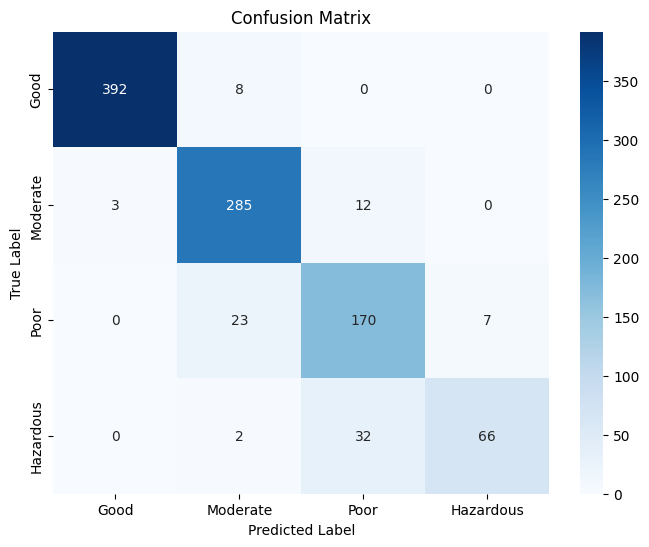

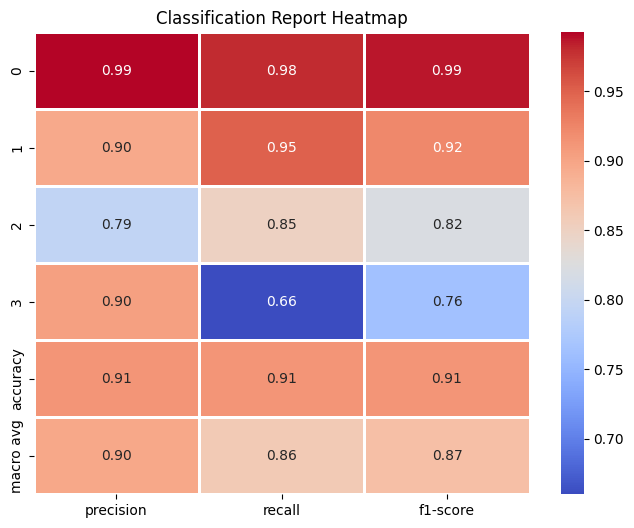

In [130]:
def plot_confusion_matrix(true_labels, preds, class_names):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(8,6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Function to visualize classification report as a heatmap
def plot_classification_report(true_labels, preds, class_names):
    report = classification_report(true_labels, preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    plt.figure(figsize=(8,6))
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm', linewidths=1, fmt=".2f")
    plt.title("Classification Report Heatmap")
    plt.show()

# Run evaluation

preds, true_labels = evaluate_model(model, test_loader)

# Plot confusion matrix
plot_confusion_matrix(true_labels, preds, dict.keys())

# Plot classification report
plot_classification_report(true_labels, preds, dict.keys())
